# Q3: Quy trình xây dựng mô hình ARIMA cho Dự báo PM2.5

Notebook này giải thích chi tiết quy trình 5 bước xây dựng mô hình ARIMA:

1. **Quan sát chuỗi gốc** - Nhận diện xu hướng và tính mùa vụ
2. **Kiểm định dừng** - Sử dụng ADF/KPSS để chọn tham số d
3. **Xem ACF/PACF** - Đoán giá trị ứng viên cho p và q
4. **Grid Search** - Tìm mô hình tối ưu theo AIC/BIC
5. **Chẩn đoán phần dư** - Kiểm tra residuals có phải white noise không

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

np.random.seed(42)

In [11]:
# Load data
PROJECT_ROOT = Path('..').resolve()
data_path = PROJECT_ROOT / 'data/processed/cleaned.parquet'

df = pd.read_parquet(data_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTime range: {df['datetime'].min()} to {df['datetime'].max()}")

# Chọn 1 trạm để phân tích ARIMA
station = df['station'].unique()[0]
print(f"\nAnalyzing station: {station}")

df_station = df[df['station'] == station].sort_values('datetime').copy()
df_station.set_index('datetime', inplace=True)

# Lấy chuỗi PM2.5
ts = df_station['PM2.5'].dropna()

# ✅ FIX WARNING: Resample để có frequency đều đặn và interpolate các gaps nhỏ
ts = ts.resample('h').mean()  # Resample về hourly
# Interpolate các gaps nhỏ (< 3 giờ), drop gaps lớn
ts = ts.interpolate(method='linear', limit=3)
ts = ts.dropna()  # Drop gaps lớn không interpolate được

print(f"\nTime series length: {len(ts)} observations")
print(f"Missing values: {ts.isna().sum()}")
print(f"Frequency: {ts.index.freq}")  # Xác nhận frequency đã set

Dataset shape: (420768, 55)
Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24']

Time range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00

Analyzing station: Aotizhongxin

Time series length: 34477 observations
Missing values: 0
Frequency: None


---

## Bước 1: Quan sát chuỗi gốc - Nhận diện Xu hướng và Mùa vụ

### Mục tiêu:
- Nhận biết có **trend** (xu hướng tăng/giảm) không?
- Nhận biết có **seasonality** (tính mùa vụ) không?
- Hiểu đặc điểm cơ bản của chuỗi trước khi modeling

BƯỚC 1: QUAN SÁT CHUỖI GỐC

📊 Thống kê mô tả:
count    34139.000000
mean        82.773611
std         82.135694
min          3.000000
25%         22.000000
50%         58.000000
75%        114.000000
max        898.000000
Name: PM2.5, dtype: float64


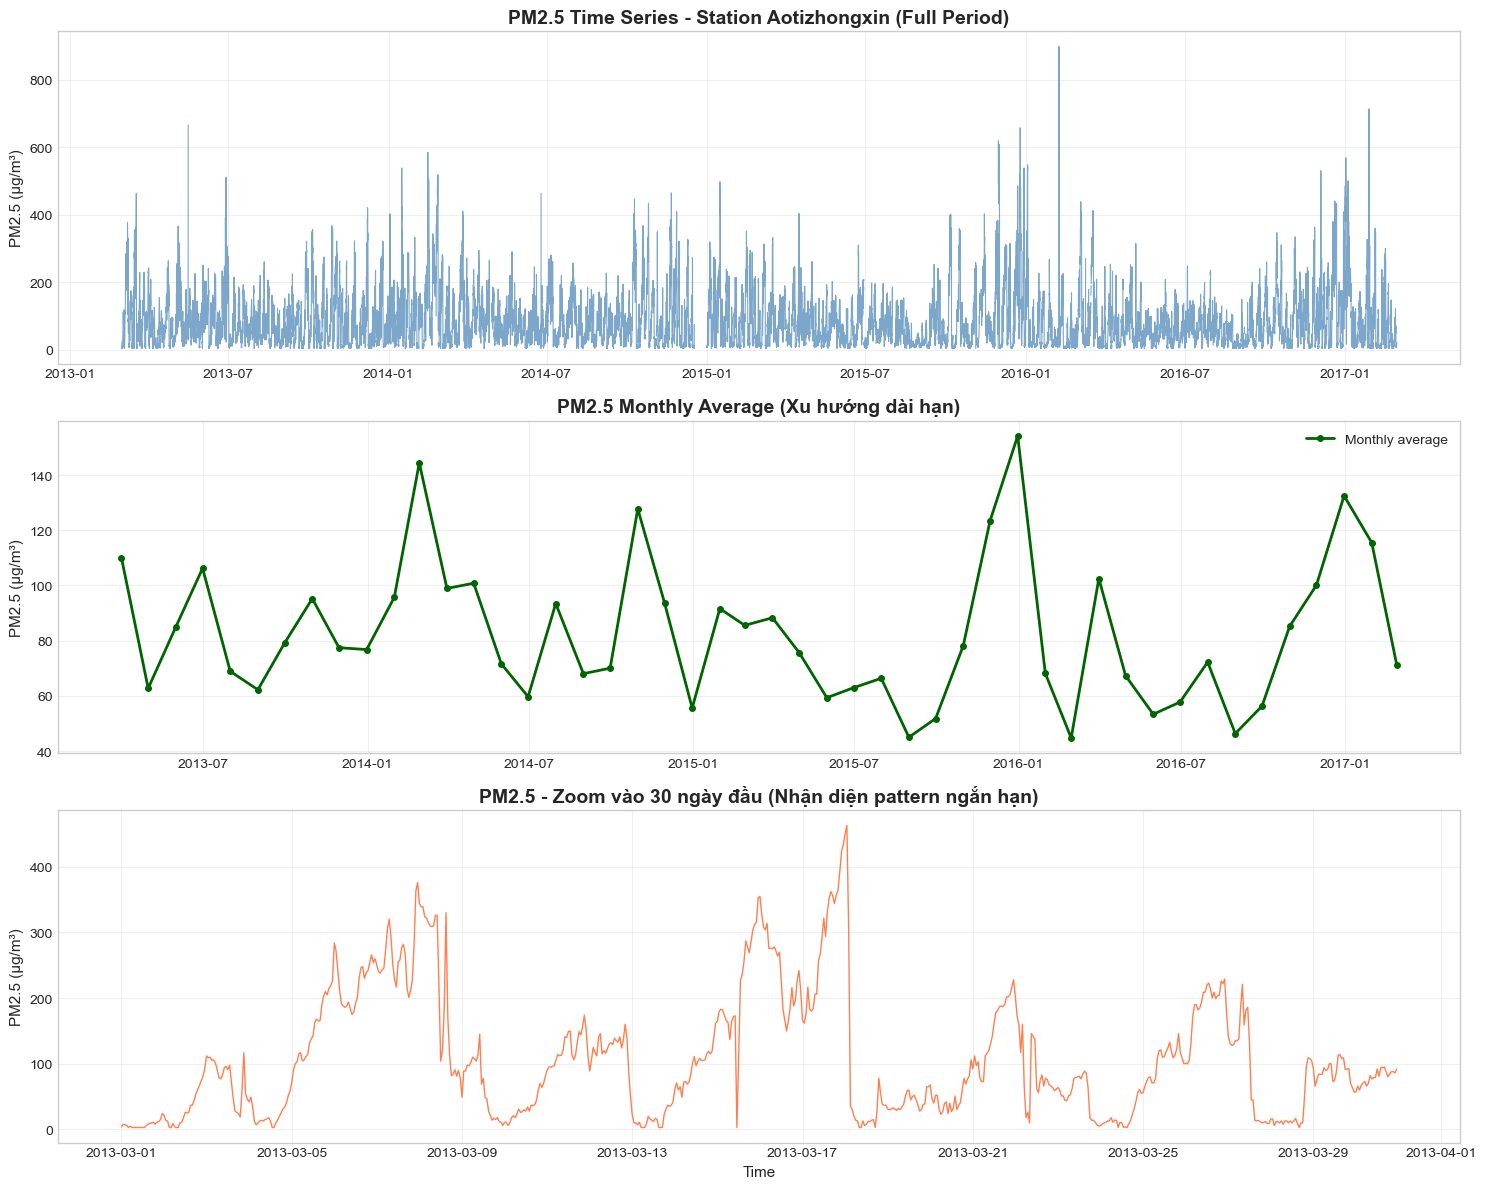


🔍 Quan sát:
  • Có xu hướng tăng/giảm dài hạn không? → Xem biểu đồ 2
  • Có pattern lặp lại theo mùa/tháng không? → So sánh các năm
  • Có chu kỳ ngắn hạn (ngày/tuần) không? → Xem biểu đồ 3


In [3]:
print("=" * 80)
print("BƯỚC 1: QUAN SÁT CHUỖI GỐC")
print("=" * 80)

# Thống kê mô tả
print("\n📊 Thống kê mô tả:")
print(ts.describe())

# Visualize full time series
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Full time series
ax1 = axes[0]
ax1.plot(ts.index, ts.values, linewidth=0.8, alpha=0.7, color='steelblue')
ax1.set_title(f'PM2.5 Time Series - Station {station} (Full Period)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax1.grid(alpha=0.3)

# 2. Monthly average (để thấy xu hướng)
ax2 = axes[1]
ts_monthly = ts.resample('M').mean()
ax2.plot(ts_monthly.index, ts_monthly.values, linewidth=2, marker='o', 
         markersize=4, color='darkgreen', label='Monthly average')
ax2.set_title('PM2.5 Monthly Average (Xu hướng dài hạn)', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Zoom vào 1 tháng để thấy pattern ngắn hạn
ax3 = axes[2]
ts_sample = ts.iloc[:24*30]  # 30 ngày đầu tiên
ax3.plot(ts_sample.index, ts_sample.values, linewidth=1, color='coral')
ax3.set_title('PM2.5 - Zoom vào 30 ngày đầu (Nhận diện pattern ngắn hạn)', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Time', fontsize=11)
ax3.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Quan sát:")
print("  • Có xu hướng tăng/giảm dài hạn không? → Xem biểu đồ 2")
print("  • Có pattern lặp lại theo mùa/tháng không? → So sánh các năm")
print("  • Có chu kỳ ngắn hạn (ngày/tuần) không? → Xem biểu đồ 3")

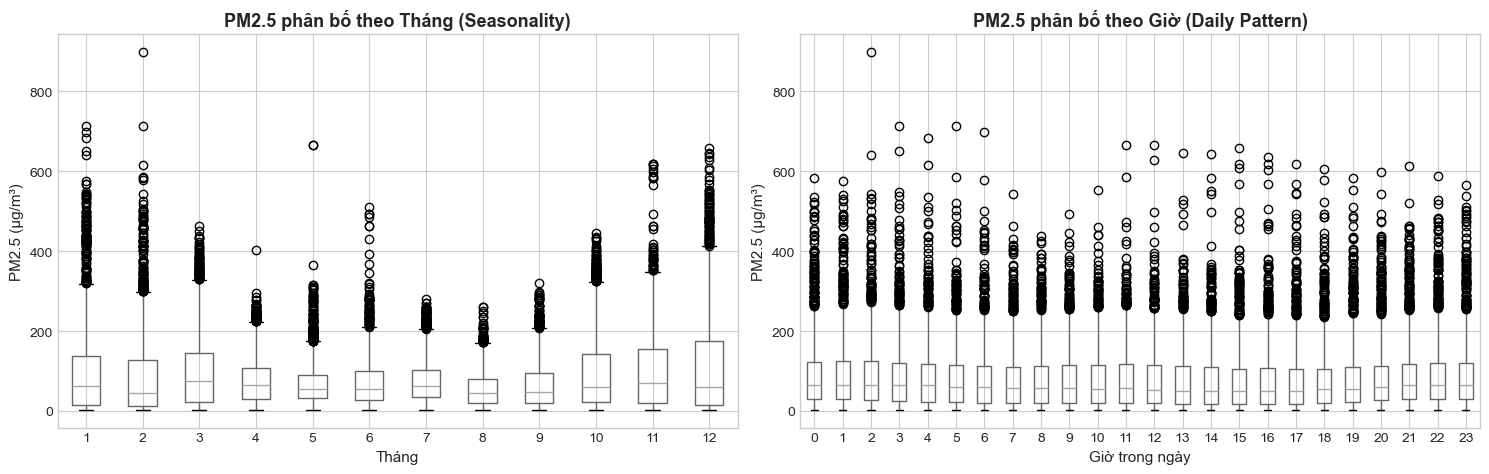


📌 Kết luận Bước 1:
  • Nếu có xu hướng rõ → Cần differencing (d ≥ 1)
  • Nếu có seasonality mạnh → Cân nhắc SARIMA
  • Nếu variance thay đổi → Cân nhắc log transform


In [4]:
# Phân tích seasonality: So sánh theo tháng và giờ
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Boxplot theo tháng
ax1 = axes[0]
df_station['month'] = df_station.index.month
df_station.boxplot(column='PM2.5', by='month', ax=ax1)
ax1.set_title('PM2.5 phân bố theo Tháng (Seasonality)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Tháng', fontsize=11)
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
plt.suptitle('')  # Remove auto-title

# 2. Boxplot theo giờ trong ngày
ax2 = axes[1]
df_station['hour'] = df_station.index.hour
df_station.boxplot(column='PM2.5', by='hour', ax=ax2)
ax2.set_title('PM2.5 phân bố theo Giờ (Daily Pattern)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Giờ trong ngày', fontsize=11)
ax2.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
plt.suptitle('')  # Remove auto-title

plt.tight_layout()
plt.show()

print("\n📌 Kết luận Bước 1:")
print("  • Nếu có xu hướng rõ → Cần differencing (d ≥ 1)")
print("  • Nếu có seasonality mạnh → Cân nhắc SARIMA")
print("  • Nếu variance thay đổi → Cân nhắc log transform")

---

## Bước 2: Kiểm định Dừng - Chọn tham số d

### Tại sao cần kiểm định dừng?
- **ARIMA yêu cầu chuỗi dừng** (stationary)
- Chuỗi dừng: Mean, variance, autocorrelation không đổi theo thời gian
- Tham số **d** = số lần differencing để làm chuỗi dừng

### Hai kiểm định bổ trợ:
1. **ADF (Augmented Dickey-Fuller):**
   - H₀: Chuỗi có unit root (không dừng)
   - p-value < 0.05 → Bác bỏ H₀ → Chuỗi dừng ✅
   
2. **KPSS (Kwiatkowski-Phillips-Schmidt-Shin):**
   - H₀: Chuỗi dừng
   - p-value > 0.05 → Chấp nhận H₀ → Chuỗi dừng ✅

In [12]:
print("=" * 80)
print("BƯỚC 2: KIỂM ĐỊNH DỪNG (STATIONARITY TESTS)")
print("=" * 80)

def check_stationarity(series, name='Series'):
    """
    Kiểm định tính dừng bằng ADF và KPSS
    """
    print(f"\n{'='*70}")
    print(f"Kiểm định: {name}")
    print(f"{'='*70}")
    
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    print("\n1️⃣ ADF Test (Augmented Dickey-Fuller):")
    print(f"   H₀: Chuỗi có unit root (không dừng)")
    print(f"   ADF Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {adf_result[1]:.4f}")
    print(f"   Critical values:")
    for key, value in adf_result[4].items():
        print(f"      {key}: {value:.4f}")
    
    if adf_result[1] < 0.05:
        print(f"   ✅ Kết luận: p-value < 0.05 → BÁC BỎ H₀ → Chuỗi DỪNG")
        adf_stationary = True
    else:
        print(f"   ❌ Kết luận: p-value ≥ 0.05 → CHẤP NHẬN H₀ → Chuỗi KHÔNG DỪNG")
        adf_stationary = False
    
    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags='auto')
    print("\n2️⃣ KPSS Test:")
    print(f"   H₀: Chuỗi dừng")
    print(f"   KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"   p-value: {kpss_result[1]:.4f}")
    print(f"   Critical values:")
    for key, value in kpss_result[3].items():
        print(f"      {key}: {value:.4f}")
    
    if kpss_result[1] > 0.05:
        print(f"   ✅ Kết luận: p-value > 0.05 → CHẤP NHẬN H₀ → Chuỗi DỪNG")
        kpss_stationary = True
    else:
        print(f"   ❌ Kết luận: p-value ≤ 0.05 → BÁC BỎ H₀ → Chuỗi KHÔNG DỪNG")
        kpss_stationary = False
    
    # Kết luận chung
    print(f"\n{'='*70}")
    if adf_stationary and kpss_stationary:
        print("✅ KẾT LUẬN: Cả 2 test đều cho thấy chuỗi DỪNG")
        return True, 0
    elif not adf_stationary and not kpss_stationary:
        print("❌ KẾT LUẬN: Cả 2 test đều cho thấy chuỗi KHÔNG DỪNG → Cần differencing")
        return False, None
    else:
        print("⚠️ KẾT LUẬN: 2 test mâu thuẫn → Cân nhắc differencing để chắc chắn")
        return False, None

# Test chuỗi gốc
is_stationary, d = check_stationarity(ts, 'Chuỗi gốc (Original Series)')

BƯỚC 2: KIỂM ĐỊNH DỪNG (STATIONARITY TESTS)

Kiểm định: Chuỗi gốc (Original Series)

1️⃣ ADF Test (Augmented Dickey-Fuller):
   H₀: Chuỗi có unit root (không dừng)
   ADF Statistic: -19.0667
   p-value: 0.0000
   Critical values:
      1%: -3.4305
      5%: -2.8616
      10%: -2.5668
   ✅ Kết luận: p-value < 0.05 → BÁC BỎ H₀ → Chuỗi DỪNG

2️⃣ KPSS Test:
   H₀: Chuỗi dừng
   KPSS Statistic: 0.2099
   p-value: 0.1000
   Critical values:
      10%: 0.3470
      5%: 0.4630
      2.5%: 0.5740
      1%: 0.7390
   ✅ Kết luận: p-value > 0.05 → CHẤP NHẬN H₀ → Chuỗi DỪNG

✅ KẾT LUẬN: Cả 2 test đều cho thấy chuỗi DỪNG


C:\Users\binhn\AppData\Local\Temp\ipykernel_4160\3508451465.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [13]:
# Nếu không dừng, thử differencing
if not is_stationary:
    print("\n" + "="*80)
    print("THỬ DIFFERENCING")
    print("="*80)
    
    d = 1
    ts_diff = ts.diff().dropna()
    max_diff = 2
    
    while d <= max_diff:
        is_stationary, _ = check_stationarity(ts_diff, f'Sau differencing d={d}')
        
        if is_stationary:
            print(f"\n🎯 CHỌN d = {d}")
            break
        else:
            if d < max_diff:
                d += 1
                ts_diff = ts_diff.diff().dropna()
                print(f"\n→ Thử differencing lần {d}...")
            else:
                print(f"\n⚠️ Sau {max_diff} lần differencing vẫn chưa dừng. Chọn d={d} và tiếp tục.")
                break
else:
    # Nếu chuỗi gốc đã dừng, không cần differencing
    print(f"\n🎯 Chuỗi gốc đã dừng → Chọn d = {d}")
    ts_diff = ts.copy()


🎯 Chuỗi gốc đã dừng → Chọn d = 0


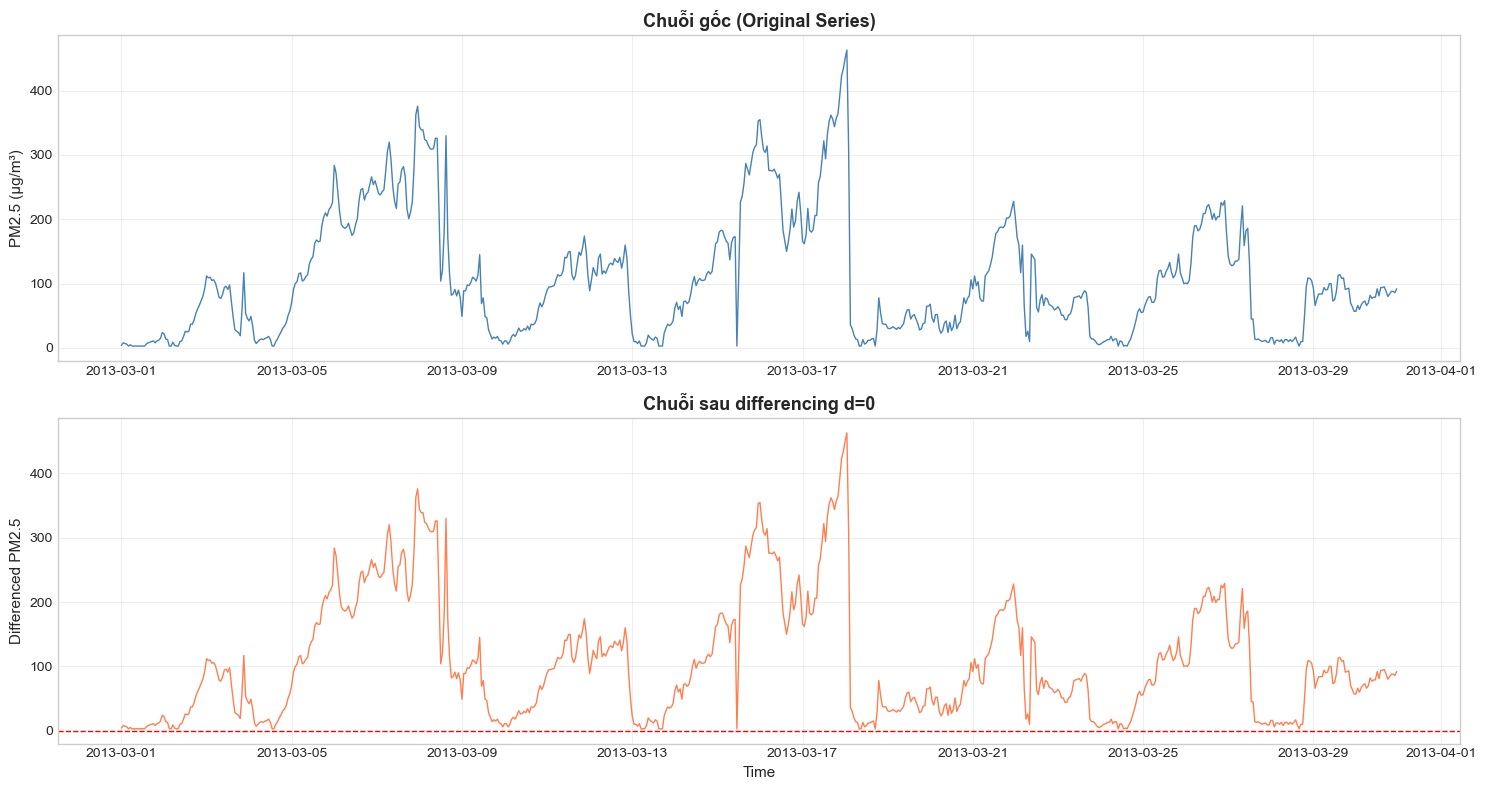


📌 Kết luận Bước 2: Chọn d = 0


In [14]:
# Visualize original vs differenced series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Original series (subset)
ax1 = axes[0]
ts_plot = ts.iloc[:24*30]  # 30 days
ax1.plot(ts_plot.index, ts_plot.values, linewidth=1, color='steelblue')
ax1.set_title('Chuỗi gốc (Original Series)', fontsize=13, fontweight='bold')
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax1.grid(alpha=0.3)

# Differenced series
ax2 = axes[1]
ts_diff_plot = ts_diff.iloc[:24*30]
ax2.plot(ts_diff_plot.index, ts_diff_plot.values, linewidth=1, color='coral')
ax2.set_title(f'Chuỗi sau differencing d={d}', fontsize=13, fontweight='bold')
ax2.set_xlabel('Time', fontsize=11)
ax2.set_ylabel('Differenced PM2.5', fontsize=11)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📌 Kết luận Bước 2: Chọn d = {d}")

---

## Bước 3: Xem ACF/PACF - Đoán p và q

### ACF và PACF là gì?

1. **ACF (Autocorrelation Function):**
   - Đo tương quan giữa $y_t$ và $y_{t-k}$
   - Giúp chọn tham số **q** (Moving Average order)

2. **PACF (Partial Autocorrelation Function):**
   - Đo tương quan giữa $y_t$ và $y_{t-k}$ sau khi loại bỏ ảnh hưởng của các lag trung gian
   - Giúp chọn tham số **p** (Autoregressive order)

### Quy tắc đoán p và q:

| Pattern | ACF | PACF | Model |
|---------|-----|------|-------|
| AR(p) | Giảm dần (decay) | Cắt đột ngột sau lag p | ARIMA(p,d,0) |
| MA(q) | Cắt đột ngột sau lag q | Giảm dần (decay) | ARIMA(0,d,q) |
| ARMA(p,q) | Giảm dần | Giảm dần | ARIMA(p,d,q) |

BƯỚC 3: XEM ACF/PACF - ĐOÁN p VÀ q


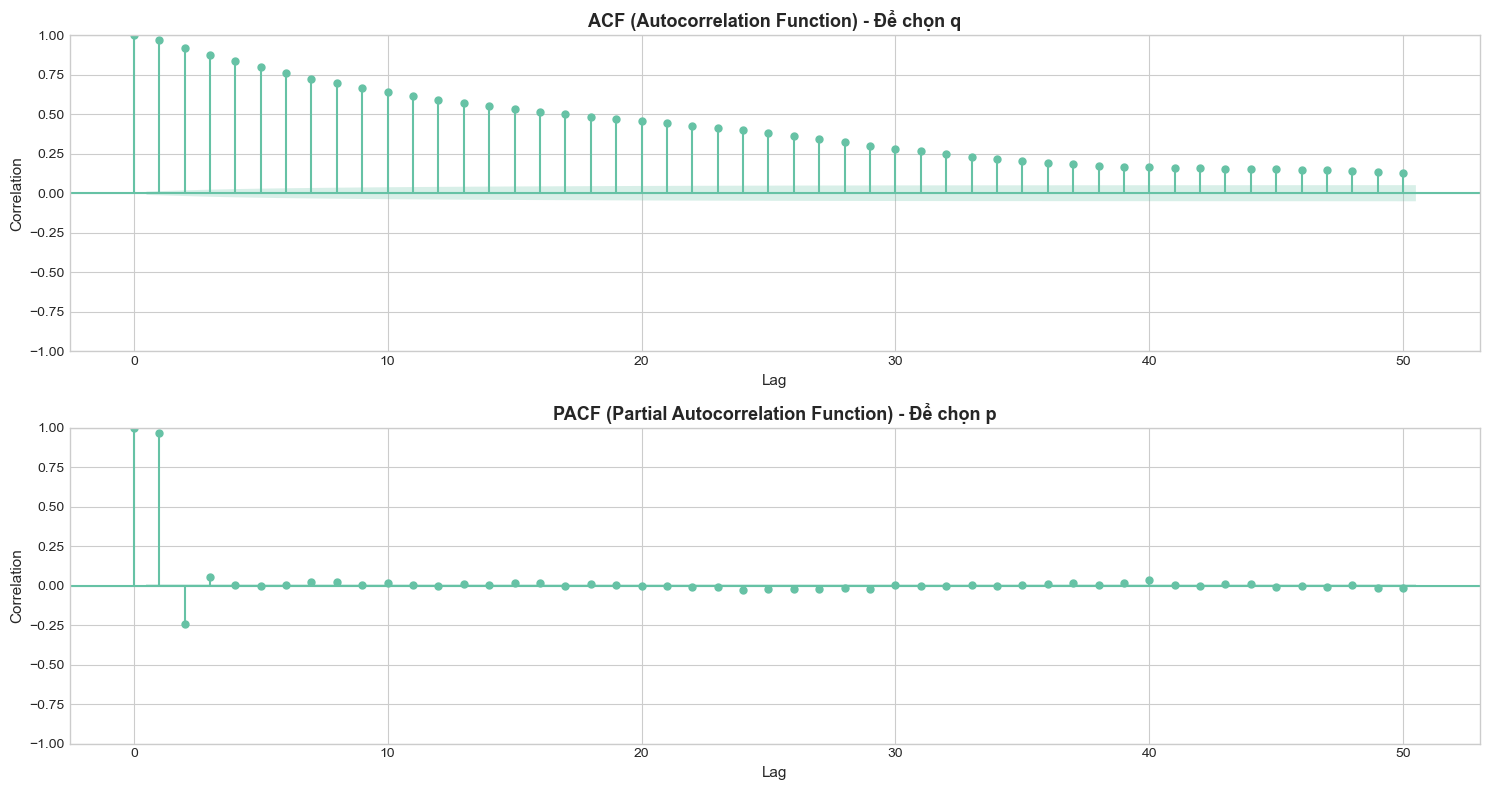


🔍 Cách đọc ACF/PACF:

1️⃣ ACF (để chọn q):
   • Đếm số lag có spike vượt qua confidence band (màu xanh)
   • Nếu ACF cắt đột ngột sau lag q → Chọn MA(q)
   • Ví dụ: ACF cắt sau lag 1 → q = 1 hoặc 2

2️⃣ PACF (để chọn p):
   • Đếm số lag có spike vượt qua confidence band
   • Nếu PACF cắt đột ngột sau lag p → Chọn AR(p)
   • Ví dụ: PACF cắt sau lag 2 → p = 1 hoặc 2

3️⃣ Cả 2 đều giảm dần → ARMA(p,q) → Dùng Grid Search

ĐỀ XUẤT RANGE CHO GRID SEARCH

📌 Dựa trên ACF/PACF:
   • Đề xuất p (AR order): thử từ 0 đến 5
   • Đề xuất q (MA order): thử từ 0 đến 5
   • d (đã chọn ở Bước 2): 0

💡 Lưu ý: Đây chỉ là gợi ý. Grid search sẽ tìm tổ hợp tốt nhất!


In [15]:
print("=" * 80)
print("BƯỚC 3: XEM ACF/PACF - ĐOÁN p VÀ q")
print("=" * 80)

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF
plot_acf(ts_diff, lags=50, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF (Autocorrelation Function) - Để chọn q', 
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=11)
axes[0].set_ylabel('Correlation', fontsize=11)

# PACF
plot_pacf(ts_diff, lags=50, ax=axes[1], alpha=0.05)
axes[1].set_title('PACF (Partial Autocorrelation Function) - Để chọn p', 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('Correlation', fontsize=11)

plt.tight_layout()
plt.show()

print("\n🔍 Cách đọc ACF/PACF:")
print("\n1️⃣ ACF (để chọn q):")
print("   • Đếm số lag có spike vượt qua confidence band (màu xanh)")
print("   • Nếu ACF cắt đột ngột sau lag q → Chọn MA(q)")
print("   • Ví dụ: ACF cắt sau lag 1 → q = 1 hoặc 2")
print("\n2️⃣ PACF (để chọn p):")
print("   • Đếm số lag có spike vượt qua confidence band")
print("   • Nếu PACF cắt đột ngột sau lag p → Chọn AR(p)")
print("   • Ví dụ: PACF cắt sau lag 2 → p = 1 hoặc 2")
print("\n3️⃣ Cả 2 đều giảm dần → ARMA(p,q) → Dùng Grid Search")

# Đề xuất range cho p và q
print("\n" + "="*80)
print("ĐỀ XUẤT RANGE CHO GRID SEARCH")
print("="*80)

# Tính ACF/PACF values
acf_values = acf(ts_diff, nlags=20, alpha=0.05)
pacf_values = pacf(ts_diff, nlags=20, alpha=0.05)

# Đếm số lag significant
acf_sig = np.where(np.abs(acf_values[0][1:]) > 2/np.sqrt(len(ts_diff)))[0]
pacf_sig = np.where(np.abs(pacf_values[0][1:]) > 2/np.sqrt(len(ts_diff)))[0]

q_suggest = min(len(acf_sig[:5]), 5) if len(acf_sig) > 0 else 2
p_suggest = min(len(pacf_sig[:5]), 5) if len(pacf_sig) > 0 else 2

print(f"\n📌 Dựa trên ACF/PACF:")
print(f"   • Đề xuất p (AR order): thử từ 0 đến {p_suggest}")
print(f"   • Đề xuất q (MA order): thử từ 0 đến {q_suggest}")
print(f"   • d (đã chọn ở Bước 2): {d}")
print(f"\n💡 Lưu ý: Đây chỉ là gợi ý. Grid search sẽ tìm tổ hợp tốt nhất!")

---

## Bước 4: Grid Search - Tìm mô hình tối ưu theo AIC/BIC

### Tại sao dùng Grid Search?
- ACF/PACF chỉ cho **gợi ý**, không chính xác 100%
- Thử nhiều tổ hợp (p, d, q) và chọn mô hình tốt nhất

### AIC và BIC là gì?

1. **AIC (Akaike Information Criterion):**
   $$AIC = 2k - 2\ln(L)$$
   - $k$: số tham số
   - $L$: likelihood
   - **Càng nhỏ càng tốt**
   - Cân bằng giữa fit và độ phức tạp

2. **BIC (Bayesian Information Criterion):**
   $$BIC = k\ln(n) - 2\ln(L)$$
   - $n$: số quan sát
   - **Càng nhỏ càng tốt**
   - Phạt model phức tạp nặng hơn AIC

### Nguyên tắc:
- BIC → mô hình đơn giản hơn (ít tham số hơn)
- AIC → mô hình phức tạp hơn (nhiều tham số hơn)
- **Thường ưu tiên BIC** để tránh overfitting

In [16]:
print("=" * 80)
print("BƯỚC 4: GRID SEARCH - TÌM MÔ HÌNH TỐI ƯU")
print("=" * 80)

# Lấy subset để train nhanh hơn (optional)
ts_train = ts.iloc[:10000]  # Lấy 10000 observations đầu
print(f"\nSử dụng {len(ts_train)} observations cho grid search")

# Define grid
p_range = range(0, min(p_suggest + 1, 4))  # Giới hạn max = 3
q_range = range(0, min(q_suggest + 1, 4))  # Giới hạn max = 3
d_fixed = d  # d đã chọn ở Bước 2

print(f"\nGrid search parameters:")
print(f"  • p: {list(p_range)}")
print(f"  • d: {d_fixed} (cố định)")
print(f"  • q: {list(q_range)}")
print(f"\nTổng số models: {len(p_range) * len(q_range)}")

# Grid search
results = []
print("\n⏳ Đang chạy grid search...\n")

for p in p_range:
    for q in q_range:
        try:
            # Fit ARIMA
            model = ARIMA(ts_train, order=(p, d_fixed, q))
            fitted = model.fit()
            
            # Lưu kết quả
            results.append({
                'p': p,
                'd': d_fixed,
                'q': q,
                'AIC': fitted.aic,
                'BIC': fitted.bic,
                'Log-Likelihood': fitted.llf
            })
            
            print(f"✓ ARIMA({p},{d_fixed},{q}) - AIC: {fitted.aic:.2f}, BIC: {fitted.bic:.2f}")
            
        except Exception as e:
            print(f"✗ ARIMA({p},{d_fixed},{q}) - Failed: {str(e)[:50]}")
            continue

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results).sort_values('BIC')

print("\n" + "="*80)
print("KẾT QUẢ GRID SEARCH (Sắp xếp theo BIC)")
print("="*80)
print(results_df.head(10).to_string(index=False))

BƯỚC 4: GRID SEARCH - TÌM MÔ HÌNH TỐI ƯU

Sử dụng 10000 observations cho grid search

Grid search parameters:
  • p: [0, 1, 2, 3]
  • d: 0 (cố định)
  • q: [0, 1, 2, 3]

Tổng số models: 16

⏳ Đang chạy grid search...



c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(0,0,0) - AIC: 116493.77, BIC: 116508.19


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(0,0,1) - AIC: 105560.10, BIC: 105581.73


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(0,0,2) - AIC: 99089.47, BIC: 99118.31


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(0,0,3) - AIC: 95653.26, BIC: 95689.31
✓ ARIMA(1,0,0) - AIC: 90065.04, BIC: 90086.67


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency informatio

✓ ARIMA(1,0,1) - AIC: 89513.37, BIC: 89542.21


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(1,0,2) - AIC: 89508.74, BIC: 89544.79


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(1,0,3) - AIC: 89500.22, BIC: 89543.48


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(2,0,0) - AIC: 89526.54, BIC: 89555.38


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(2,0,1) - AIC: 89510.25, BIC: 89546.30


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(2,0,2) - AIC: 89504.31, BIC: 89547.57


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(2,0,3) - AIC: 89499.58, BIC: 89550.05


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(3,0,0) - AIC: 89505.62, BIC: 89541.67


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(3,0,1) - AIC: 89500.17, BIC: 89543.43


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(3,0,2) - AIC: 89502.73, BIC: 89553.20


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✓ ARIMA(3,0,3) - AIC: 89503.70, BIC: 89561.38

KẾT QUẢ GRID SEARCH (Sắp xếp theo BIC)
 p  d  q          AIC          BIC  Log-Likelihood
 3  0  0 89505.616796 89541.668498   -44747.808398
 1  0  1 89513.373090 89542.214452   -44752.686545
 3  0  1 89500.168299 89543.430341   -44744.084149
 1  0  3 89500.217078 89543.479120   -44744.108539
 1  0  2 89508.741516 89544.793218   -44749.370758
 2  0  1 89510.250568 89546.302269   -44750.125284
 2  0  2 89504.310611 89547.572653   -44746.155305
 2  0  3 89499.576937 89550.049320   -44742.788469
 3  0  2 89502.725246 89553.197629   -44744.362623
 2  0  0 89526.538971 89555.380332   -44759.269485


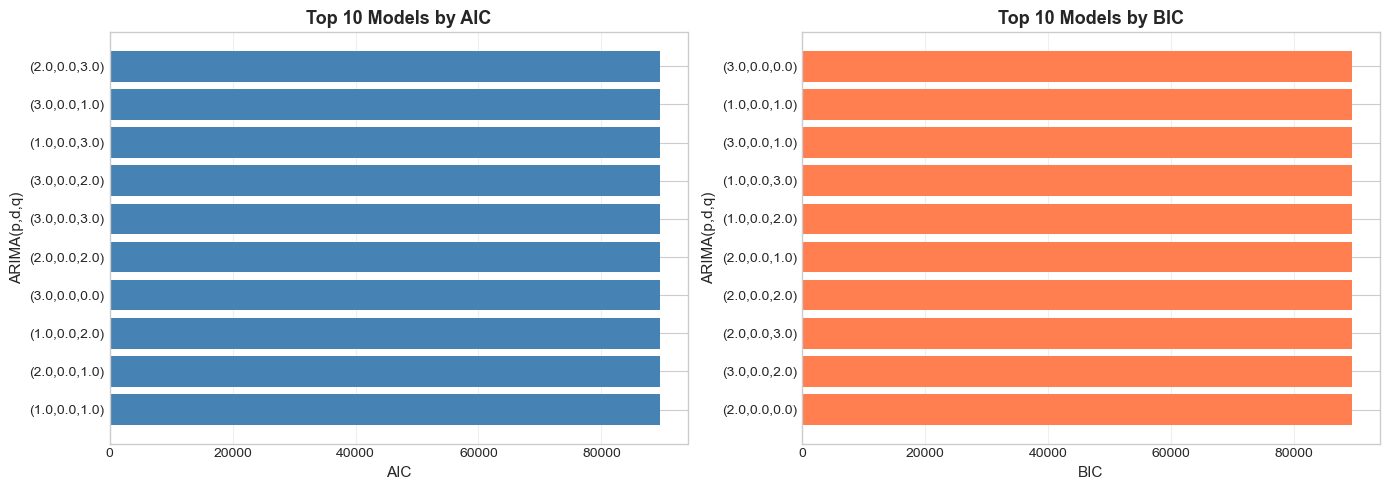


MÔ HÌNH TỐI ƯU

🏆 Best model (theo BIC): ARIMA(3, 0, 0)
   • AIC: 89505.62
   • BIC: 89541.67
   • Log-Likelihood: -44747.81

📌 Kết luận Bước 4: Chọn ARIMA(3, 0, 0)


In [17]:
# Visualize AIC/BIC comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tạo labels cho x-axis
results_df['model'] = results_df.apply(lambda x: f"({x['p']},{x['d']},{x['q']})", axis=1)

# Plot AIC
ax1 = axes[0]
top_10_aic = results_df.nsmallest(10, 'AIC')
ax1.barh(top_10_aic['model'], top_10_aic['AIC'], color='steelblue')
ax1.set_xlabel('AIC', fontsize=11)
ax1.set_ylabel('ARIMA(p,d,q)', fontsize=11)
ax1.set_title('Top 10 Models by AIC', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot BIC
ax2 = axes[1]
top_10_bic = results_df.nsmallest(10, 'BIC')
ax2.barh(top_10_bic['model'], top_10_bic['BIC'], color='coral')
ax2.set_xlabel('BIC', fontsize=11)
ax2.set_ylabel('ARIMA(p,d,q)', fontsize=11)
ax2.set_title('Top 10 Models by BIC', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Chọn mô hình tốt nhất
best_model_bic = results_df.iloc[0]
best_p = int(best_model_bic['p'])
best_d = int(best_model_bic['d'])
best_q = int(best_model_bic['q'])

print("\n" + "="*80)
print("MÔ HÌNH TỐI ƯU")
print("="*80)
print(f"\n🏆 Best model (theo BIC): ARIMA({best_p}, {best_d}, {best_q})")
print(f"   • AIC: {best_model_bic['AIC']:.2f}")
print(f"   • BIC: {best_model_bic['BIC']:.2f}")
print(f"   • Log-Likelihood: {best_model_bic['Log-Likelihood']:.2f}")
print(f"\n📌 Kết luận Bước 4: Chọn ARIMA({best_p}, {best_d}, {best_q})")

---

## Bước 5: Chẩn đoán Phần dư - Kiểm tra Residuals

### Tại sao phải kiểm tra residuals?
- **Mô hình tốt** → residuals phải là **white noise** (nhiễu trắng)
- White noise = không có cấu trúc, không có pattern
- Nếu residuals còn cấu trúc → Mô hình chưa bắt hết thông tin

### Các kiểm tra:

1. **Residuals plot:**
   - Nên dao động quanh 0
   - Không có trend
   - Variance đồng đều

2. **Histogram + QQ plot:**
   - Residuals nên phân phối chuẩn (Gaussian)
   - QQ plot: điểm nên nằm trên đường thẳng

3. **ACF của residuals:**
   - Không có spike vượt qua confidence band
   - → Không còn autocorrelation

4. **Ljung-Box test:**
   - H₀: Residuals là white noise (không có autocorrelation)
   - p-value > 0.05 → Chấp nhận H₀ → Residuals OK ✅

In [18]:
print("=" * 80)
print("BƯỚC 5: CHẨN ĐOÁN PHẦN DƯ (RESIDUAL DIAGNOSTICS)")
print("=" * 80)

# Fit best model trên toàn bộ training data
print(f"\nFitting ARIMA({best_p}, {best_d}, {best_q}) trên toàn bộ training set...")
best_model = ARIMA(ts_train, order=(best_p, best_d, best_q))
best_fitted = best_model.fit()

print("\n✅ Model fitted!")
print(f"\nModel summary:")
print(best_fitted.summary())

# Extract residuals
residuals = best_fitted.resid

BƯỚC 5: CHẨN ĐOÁN PHẦN DƯ (RESIDUAL DIAGNOSTICS)

Fitting ARIMA(3, 0, 0) trên toàn bộ training set...


c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\binhn\anaconda3\envs\beijing_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



✅ Model fitted!

Model summary:
                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                10000
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -44747.808
Date:                Mon, 19 Jan 2026   AIC                          89505.617
Time:                        11:07:32   BIC                          89541.668
Sample:                             0   HQIC                         89517.820
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.6850      6.637     13.512      0.000      76.676     102.694
ar.L1          1.1958      0.003    349.743      0.000       1.189       1.202
ar.L2         -0.28

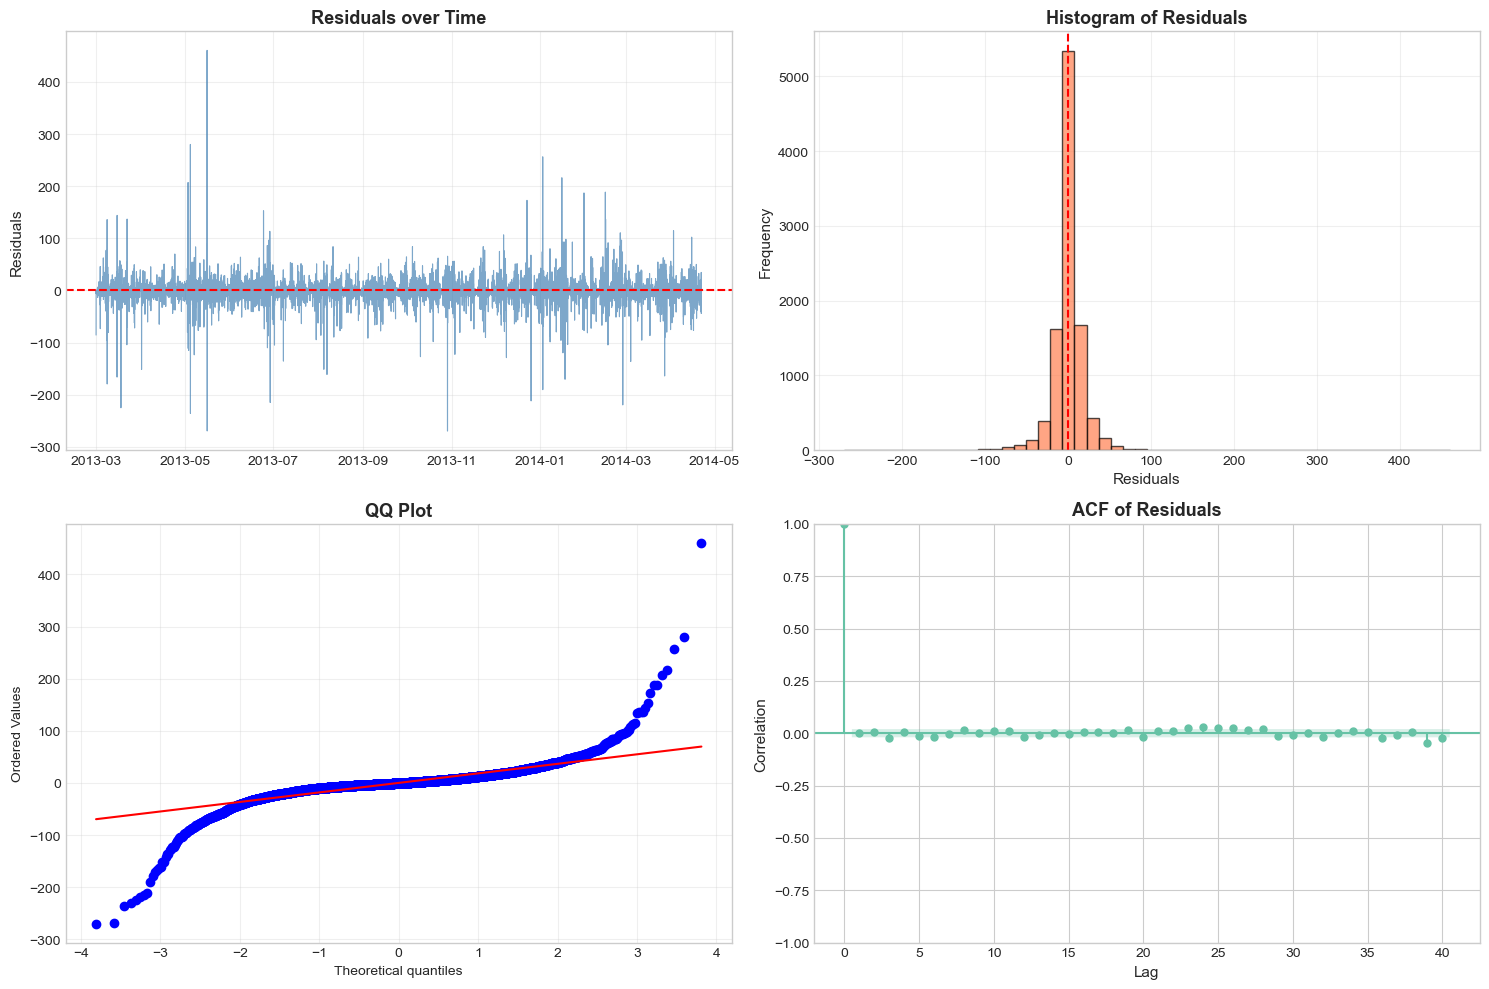

In [19]:
# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residuals plot
ax1 = axes[0, 0]
ax1.plot(residuals, linewidth=0.8, alpha=0.7, color='steelblue')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax1.set_title('Residuals over Time', fontsize=13, fontweight='bold')
ax1.set_ylabel('Residuals', fontsize=11)
ax1.grid(alpha=0.3)

# 2. Histogram
ax2 = axes[0, 1]
ax2.hist(residuals, bins=50, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax2.set_title('Histogram of Residuals', fontsize=13, fontweight='bold')
ax2.set_xlabel('Residuals', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.grid(alpha=0.3)

# 3. QQ plot
ax3 = axes[1, 0]
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('QQ Plot', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. ACF of residuals
ax4 = axes[1, 1]
plot_acf(residuals, lags=40, ax=ax4, alpha=0.05)
ax4.set_title('ACF of Residuals', fontsize=13, fontweight='bold')
ax4.set_xlabel('Lag', fontsize=11)
ax4.set_ylabel('Correlation', fontsize=11)

plt.tight_layout()
plt.show()

In [20]:
# Ljung-Box test
print("\n" + "="*80)
print("LJUNG-BOX TEST (Kiểm tra White Noise)")
print("="*80)
print("\nH₀: Residuals là white noise (không có autocorrelation)")
print("Nếu p-value > 0.05 → Residuals OK ✅\n")

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(lb_test)

# Kết luận
all_pass = (lb_test['lb_pvalue'] > 0.05).all()

print("\n" + "="*80)
if all_pass:
    print("✅ KẾT LUẬN: Tất cả p-values > 0.05")
    print("   → Residuals là white noise")
    print("   → Mô hình đã bắt được cấu trúc chính của chuỗi")
    print("   → Mô hình TỐT! ✅")
else:
    print("⚠️ KẾT LUẬN: Một số p-values < 0.05")
    print("   → Residuals còn autocorrelation")
    print("   → Mô hình chưa bắt hết cấu trúc")
    print("   → Cần cải thiện: thử p, q lớn hơn hoặc SARIMA")


LJUNG-BOX TEST (Kiểm tra White Noise)

H₀: Residuals là white noise (không có autocorrelation)
Nếu p-value > 0.05 → Residuals OK ✅

      lb_stat  lb_pvalue
10  15.742934   0.107231
20  26.165520   0.160415
30  62.997536   0.000393

⚠️ KẾT LUẬN: Một số p-values < 0.05
   → Residuals còn autocorrelation
   → Mô hình chưa bắt hết cấu trúc
   → Cần cải thiện: thử p, q lớn hơn hoặc SARIMA


In [21]:
# Additional statistics
print("\n" + "="*80)
print("THỐNG KÊ RESIDUALS")
print("="*80)
print(f"\nMean: {residuals.mean():.4f} (nên gần 0)")
print(f"Std: {residuals.std():.4f}")
print(f"Skewness: {residuals.skew():.4f} (nên gần 0)")
print(f"Kurtosis: {residuals.kurtosis():.4f} (nên gần 0 cho phân phối chuẩn)")

# Normality test
from scipy.stats import shapiro
stat, p_value = shapiro(residuals[:5000])  # Shapiro test với max 5000 samples
print(f"\nShapiro-Wilk Test (Normality):")
print(f"  Statistic: {stat:.4f}")
print(f"  p-value: {p_value:.4f}")
if p_value > 0.05:
    print("  ✅ Residuals có phân phối chuẩn")
else:
    print("  ⚠️ Residuals không hoàn toàn phân phối chuẩn (thường xảy ra với dữ liệu lớn)")


THỐNG KÊ RESIDUALS

Mean: -0.0047 (nên gần 0)
Std: 21.2533
Skewness: 0.1858 (nên gần 0)
Kurtosis: 50.3784 (nên gần 0 cho phân phối chuẩn)

Shapiro-Wilk Test (Normality):
  Statistic: 0.6795
  p-value: 0.0000
  ⚠️ Residuals không hoàn toàn phân phối chuẩn (thường xảy ra với dữ liệu lớn)


---

## 📋 Tổng kết: Quy trình ARIMA cho Báo cáo

### **Quy trình 5 bước xây dựng mô hình ARIMA:**

#### **Bước 1: Quan sát chuỗi gốc**
- **Mục tiêu:** Nhận diện xu hướng (trend) và tính mùa vụ (seasonality)
- **Cách làm:**
  - Plot chuỗi thời gian full và theo tháng
  - Xem boxplot theo tháng/giờ để phát hiện seasonality
  - Quan sát variance có thay đổi không?
- **Kết luận:** Có trend/seasonality → Cần differencing hoặc SARIMA

---

#### **Bước 2: Kiểm định dừng (Stationarity Tests)**
- **Mục tiêu:** Chọn tham số **d** (order of differencing)
- **Cách làm:**
  - **ADF test:** H₀ = không dừng → p < 0.05 → dừng ✅
  - **KPSS test:** H₀ = dừng → p > 0.05 → dừng ✅
  - Nếu chưa dừng → differencing và test lại
- **Kết luận:** Chọn d = số lần differencing cần thiết (thường d = 0, 1, hoặc 2)

---

#### **Bước 3: Xem ACF/PACF**
- **Mục tiêu:** Đoán giá trị ứng viên cho **p** và **q**
- **Cách làm:**
  - Plot ACF → Đếm số lag significant → gợi ý q (MA order)
  - Plot PACF → Đếm số lag significant → gợi ý p (AR order)
  - **Quy tắc:**
    - ACF cắt sau lag q, PACF giảm dần → MA(q) → ARIMA(0,d,q)
    - PACF cắt sau lag p, ACF giảm dần → AR(p) → ARIMA(p,d,0)
    - Cả 2 giảm dần → ARMA(p,q) → Grid search
- **Kết luận:** Đề xuất range: p ∈ [0, 3], q ∈ [0, 3]

---

#### **Bước 4: Grid Search với AIC/BIC**
- **Mục tiêu:** Tìm tổ hợp (p, d, q) tối ưu
- **Cách làm:**
  - Giữ d cố định (đã chọn ở Bước 2)
  - Thử tất cả tổ hợp p, q nhỏ (ví dụ: p, q ∈ [0, 3])
  - Tính AIC và BIC cho mỗi model
  - **AIC:** Ưu tiên model phức tạp hơn
  - **BIC:** Ưu tiên model đơn giản hơn (phạt nặng hơn)
- **Kết luận:** Chọn model có **BIC nhỏ nhất** (thường ưu tiên BIC)

---

#### **Bước 5: Chẩn đoán phần dư (Residual Diagnostics)**
- **Mục tiêu:** Kiểm tra residuals có phải **white noise** không
- **Cách làm:**
  1. **Plot residuals:** Nên dao động quanh 0, không có trend
  2. **Histogram + QQ plot:** Residuals nên phân phối chuẩn
  3. **ACF residuals:** Không có spike vượt confidence band
  4. **Ljung-Box test:** H₀ = white noise → p > 0.05 → OK ✅
- **Kết luận:**
  - Nếu residuals là white noise → **Mô hình TỐT** ✅
  - Nếu còn autocorrelation → Cần cải thiện (thử p, q lớn hơn hoặc SARIMA)

---

### **Ý nghĩa của từng bước:**

| Bước | Mục tiêu | Output | Ý nghĩa |
|------|----------|--------|--------|
| 1. Quan sát | Hiểu dữ liệu | Có trend/seasonality? | Quyết định có cần SARIMA không |
| 2. Kiểm định dừng | Chọn d | d = 0, 1, 2 | Làm chuỗi dừng để ARIMA hoạt động |
| 3. ACF/PACF | Chọn p, q | Range cho p, q | Gợi ý ban đầu cho grid search |
| 4. Grid Search | Tối ưu mô hình | Best (p,d,q) | Tìm model tốt nhất theo AIC/BIC |
| 5. Chẩn đoán | Validate model | Residuals OK? | Đảm bảo model bắt hết cấu trúc |

---

### **Câu trả lời cho Báo cáo:**

**Quy trình xây dựng ARIMA gồm 5 bước:**

1. **Quan sát chuỗi gốc:** Plot để nhận diện trend và seasonality
2. **Kiểm định dừng:** ADF/KPSS test → Chọn d
3. **Xem ACF/PACF:** Đoán range cho p và q
4. **Grid search:** Giữ d cố định, thử các (p,q) nhỏ, chọn model theo BIC
5. **Chẩn đoán residuals:** Ljung-Box test + ACF plot → Đảm bảo residuals là white noise

→ **Nếu residuals là white noise** → Mô hình đã bắt được cấu trúc chính của chuỗi ✅

---

## 🎯 Kết luận cuối cùng

### Mô hình tối ưu cho dữ liệu này:

In [22]:
print("=" * 80)
print("KẾT LUẬN CUỐI CÙNG")
print("=" * 80)
print(f"\n🏆 Mô hình tối ưu: ARIMA({best_p}, {best_d}, {best_q})")
print(f"\n📊 Các tham số:")
print(f"   • p = {best_p}: AR order (dựa trên PACF)")
print(f"   • d = {best_d}: Differencing order (dựa trên ADF/KPSS)")
print(f"   • q = {best_q}: MA order (dựa trên ACF)")
print(f"\n📈 Model metrics:")
print(f"   • AIC: {best_model_bic['AIC']:.2f}")
print(f"   • BIC: {best_model_bic['BIC']:.2f}")
print(f"\n✅ Residuals diagnostics:")
if all_pass:
    print(f"   • Ljung-Box test: PASSED (residuals là white noise)")
    print(f"   • Mô hình đã bắt được cấu trúc chính của chuỗi")
else:
    print(f"   • Ljung-Box test: Cần cải thiện")
    print(f"   • Khuyến nghị: Thử SARIMA hoặc p, q lớn hơn")
print("\n" + "="*80)

KẾT LUẬN CUỐI CÙNG

🏆 Mô hình tối ưu: ARIMA(3, 0, 0)

📊 Các tham số:
   • p = 3: AR order (dựa trên PACF)
   • d = 0: Differencing order (dựa trên ADF/KPSS)
   • q = 0: MA order (dựa trên ACF)

📈 Model metrics:
   • AIC: 89505.62
   • BIC: 89541.67

✅ Residuals diagnostics:
   • Ljung-Box test: Cần cải thiện
   • Khuyến nghị: Thử SARIMA hoặc p, q lớn hơn

